# SHO Fitting Data

## Import Packages

In [9]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [10]:
%load_ext autoreload
# import gdown
import time
import h5py
import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.be.util import print_be_tree
from m3_learning.be.processing import convert_amp_phase, fit_loop_function, SHO_Fitter, SHO_fit_to_array, loop_lsqf
from m3_learning.viz.layout import layout_fig, Axis_Ratio
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './figures/')

from scipy.signal import resample
from scipy import fftpack


set_style("printing")
random_seed(seed=42)

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [11]:
path = r"./"

In [12]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = 'data_raw.h5'
save_path = './'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


Prints the Tree to show the Data Structure

In [13]:
from m3_learning.util.h5_util import print_tree
from BGlib import be as belib
import pyUSID as usid
import os
import sidpy
import numpy as np
import h5py
import time
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.viz.printing import printer
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from m3_learning.viz.layout import layout_fig
from scipy.signal import resample
from scipy import fftpack
from sklearn.preprocessing import StandardScaler
from m3_learning.util.preprocessing import global_scaler
from m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from m3_learning.be.processing import convert_amp_phase


class BE_Dataset:

    def __init__(self, dataset, 
                 scaled = False, 
                 raw_format = "complex", 
                 fitter = 'LSQF', 
                 output_shape = 'pixels',
                 measurement_state = 'all',
                 resampled = False, 
                 resampled_bins = 80,
                 **kwargs):
        self.dataset = dataset
        self.resampled = resampled
        self.scaled = scaled
        self.raw_format = raw_format
        self.fitter = fitter
        self.output_shape = output_shape
        self.measurement_state = measurement_state
        self.resampled_bins = 80
        
        for key, value in kwargs.items():
            setattr(self, key, value)
        
        self.set_raw_data()
        self.set_raw_data_resampler()
        self.set_SHO_LSQF()
        self.raw_data_scaler = self.Raw_Data_Scaler(self.raw_data)
        
    
    def print_be_tree(self):
        """Utility file to print the Tree of a BE Dataset

        Args:
            path (str): path to the h5 file
        """

        with h5py.File(self.dataset, "r+") as h5_f:

            # Inspects the h5 file
            usid.hdf_utils.print_tree(h5_f)

            # prints the structure and content of the file
            print(
                "Datasets and datagroups within the file:\n------------------------------------")
            print_tree(h5_f.file)

            print("\nThe main dataset:\n------------------------------------")
            print(h5_f)
            print("\nThe ancillary datasets:\n------------------------------------")
            print(h5_f.file["/Measurement_000/Channel_000/Position_Indices"])
            print(h5_f.file["/Measurement_000/Channel_000/Position_Values"])
            print(
                h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Indices"])
            print(
                h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Values"])

            print(
                "\nMetadata or attributes in a datagroup\n------------------------------------")
            for key in h5_f.file["/Measurement_000"].attrs:
                print("{} : {}".format(
                    key, h5_f.file["/Measurement_000"].attrs[key]))
    
    def data_writer(self, base, name, data):
        with h5py.File(self.dataset, "r+") as h5_f:
            try:
                make_dataset(h5_f[base],
                             name,
                             data)
            except:
                self.delete(f"{base}/{name}")
                make_dataset(h5_f[base],
                             name,
                             data)
                
    # delete a dataset
    def delete(self, name):
        with h5py.File(self.dataset, "r+") as h5_f:
            try:
                del h5_f[name]
            except KeyError:
                print("Dataset not found, could not be deleted")
                
    def SHO_Fitter(self, force=False, max_cores=-1, max_mem=1024*8):
        """Function that computes the SHO fit results

        Args:
            force (bool, optional): forces the SHO results to be computed from scratch. Defaults to False.
            max_cores (int, optional): number of processor cores to use. Defaults to -1.
            max_mem (_type_, optional): maximum ram to use. Defaults to 1024*8.
        """

        #TODO fix delete
        # if force:
        #     self.delete(None)
        
        start_time_lsqf = time.time()

        (data_dir, filename) = os.path.split(self.dataset)

        if self.dataset.endswith(".h5"):
            # No translation here
            h5_path = self.dataset

            tl = belib.translators.LabViewH5Patcher()
            tl.translate(h5_path, force_patch=force)

        else:
            pass

        folder_path, h5_raw_file_name = os.path.split(h5_path)
        h5_file = h5py.File(h5_path, "r+")
        print("Working on:\n" + h5_path)

        h5_main = usid.hdf_utils.find_dataset(h5_file, "Raw_Data")[0]

        h5_pos_inds = h5_main.h5_pos_inds
        pos_dims = h5_main.pos_dim_sizes
        pos_labels = h5_main.pos_dim_labels
        print(pos_labels, pos_dims)

        h5_meas_grp = h5_main.parent.parent

        parm_dict = sidpy.hdf_utils.get_attributes(h5_meas_grp)

        expt_type = usid.hdf_utils.get_attr(h5_file, "data_type")

        is_ckpfm = expt_type == "cKPFMData"
        if is_ckpfm:
            num_write_steps = parm_dict["VS_num_DC_write_steps"]
            num_read_steps = parm_dict["VS_num_read_steps"]
            num_fields = 2

        if expt_type != "BELineData":
            vs_mode = usid.hdf_utils.get_attr(h5_meas_grp, "VS_mode")
            try:
                field_mode = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_measure_in_field_loops")
            except KeyError:
                print("field mode could not be found. Setting to default value")
                field_mode = "out-of-field"
            try:
                vs_cycle_frac = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_cycle_fraction")
            except KeyError:
                print("VS cycle fraction could not be found. Setting to default value")
                vs_cycle_frac = "full"

        sho_fit_points = 5  # The number of data points at each step to use when fitting
        sho_override = force  # Force recompute if True

        h5_sho_targ_grp = None
        h5_sho_file_path = os.path.join(
            folder_path, h5_raw_file_name)

        print("\n\nSHO Fits will be written to:\n" + h5_sho_file_path + "\n\n")
        f_open_mode = "w"
        if os.path.exists(h5_sho_file_path):
            f_open_mode = "r+"
        h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
        h5_sho_targ_grp = h5_sho_file

        sho_fitter = belib.analysis.BESHOfitter(
            h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp
        )
        sho_fitter.set_up_guess(
            guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
            num_points=sho_fit_points,
        )
        h5_sho_guess = sho_fitter.do_guess(override=sho_override)
        sho_fitter.set_up_fit()
        h5_sho_fit = sho_fitter.do_fit(override=sho_override)
        parms_dict = parms_dict = sidpy.hdf_utils.get_attributes(
            h5_main.parent.parent)

        print(
            f"LSQF method took {time.time() - start_time_lsqf} seconds to compute parameters")
    
    @property
    def spectroscopic_values(self):
        """Spectroscopic values"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"][:]
        
    @property
    def be_repeats(self):
        """Number of BE repeats"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f['Measurement_000'].attrs["BE_repeats"]

    @property
    def num_bins(self):
        """Number of frequency bins in the data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["num_bins"]

    @property
    def num_pix(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["num_pix"]

    @property
    def num_pix_1d(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return int(np.sqrt(self.num_pix))

    @property
    def voltage_steps(self):
        """Number of DC voltage steps"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["num_udvs_steps"]

    @property
    def sampling_rate(self):
        """Sampling rate in Hz"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]

    @property
    def be_bandwidth(self):
        """BE bandwidth in Hz"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

    @property
    def be_center_frequency(self):
        """BE center frequency in Hz"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]

    @property
    def frequency_bin(self):
        """Frequency bin vector in Hz"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]
    
    @property
    def be_waveform(self):
        """BE excitation waveform"""
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Excitation_Waveform"][:]

    @property
    def hysteresis_waveform(self, loop_number=2):
        with h5py.File(self.dataset, "r+") as h5_f:
            return (
                self.spectroscopic_values[1, ::len(self.frequency_bin)][int(self.voltage_steps/loop_number):] *
                self.spectroscopic_values[2, ::len(
                    self.frequency_bin)][int(self.voltage_steps/loop_number):]
            )
            
    # raw_be_data as complex    
    @property
    def original_data(self):
        with h5py.File(self.dataset, "r+") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Raw_Data"][:]
        
    def raw_data(self, pixel=None, voltage_step=None):
        """Raw data"""
        if pixel is not None and voltage_step is not None:
            with h5py.File(self.dataset, "r+") as h5_f:
                return h5_f["Measurement_000"]["Channel_000"]["Raw_Data_Reshaped"][[pixel], :, :][:, [voltage_step], :]
        else: 
            with h5py.File(self.dataset, "r+") as h5_f:
                return h5_f["Measurement_000"]["Channel_000"]["Raw_Data_Reshaped"][:]
        
    
    def set_raw_data(self):
        with h5py.File(self.dataset, "r+") as h5_f:
            self.data_writer("Measurement_000/Channel_000", "Raw_Data_Reshaped", self.original_data.reshape(self.num_pix, self.voltage_steps, self.num_bins))
    
    
    # def get_1d_index(self, arr_shape, i, j):
    #     m, n = arr_shape
    #     index = i * n + j
    #     return index
        
    def SHO_Scaler(self, 
                save_loc='SHO_LSQF_scaled',
                basepath="Raw_Data-SHO_Fit_000"):
        
        self.SHO_scaler = StandardScaler()
        data = self.SHO_LSQF().reshape(-1, 4)
        
        phase_data = data[:, 3]

        self.SHO_scaler.fit(data)

        # sets the phase not to scale
        self.SHO_scaler.mean_[3] = 0
        self.SHO_scaler.var_[3] = 1
        self.SHO_scaler.scale_[3] = 1

        fit_results_scaled = self.SHO_scaler.transform(
            data).reshape(self.num_pix, -1, 4)
        
        

        with h5py.File(self.dataset, "r+") as h5_f:
            self.data_writer(
                basepath, save_loc, fit_results_scaled)
            
    
    def SHO_LSQF(self, pixel=None, voltage_step=None):
        with h5py.File(self.dataset, "r+") as h5_f:
            if pixel is not None and voltage_step is not None:
                return h5_f['/Raw_Data-SHO_Fit_000/SHO_LSQF'][[pixel], :, :][:, [voltage_step], :]
            else:
                return h5_f['/Raw_Data-SHO_Fit_000/SHO_LSQF'][:]


    def set_SHO_LSQF(self, phase_shift=None, basepath = "Raw_Data-SHO_Fit_000", save_loc='SHO_LSQF'):
        """Utility function to convert the SHO fit results to an array

        Args:
            SHO_LSQF (h5 Dataset): Location of the fit results in an h5 file

        Returns:
            np.array: SHO fit results
        """
        with h5py.File(self.dataset, "r+") as h5_f:

            # create a list for parameters
            SHO_LSQF_list = []
            for sublist in np.array(
                h5_f['/Raw_Data-SHO_Fit_000/Fit']
            ):
                for item in sublist:
                    for i in item:
                        SHO_LSQF_list.append(i)

            data_ = np.array(SHO_LSQF_list).reshape(
                -1, 5)
            
            if phase_shift is not None:
                data_[:, 3] = self.shift_phase(data_[:, 3], phase_shift)
            
            # writes all but the r2
            self.data_writer(
                basepath, save_loc, data_.reshape(
                    self.num_pix, self.voltage_steps, 5)[:,:,:-1])
            
            self.SHO_Scaler()
        # # changes the pixel to collect the value for the on or off state
        #     if self.measurement_state == 'on':
        #         pixel = np.arange(0,self.voltage_steps)[1::2][pixel]
        #     elif self.measurement_state == 'off':
        #         pixel = np.arange(0, self.voltage_steps)[::2][pixel]

    
    def shift_phase(self, phase, shift_=None):

            if shift_ is None:
                return phase
            else:
                shift = shift_

            phase_ = phase.copy()
            phase_ += np.pi
            phase_[phase_ <= shift] += 2 *\
                np.pi  # shift phase values greater than pi
            return phase_ - shift - np.pi
        
    def raw_data_resampled(self, pixel = None, voltage_step = None):
        """Resampled real part of the complex data resampled"""
        if pixel is not None and voltage_step is not None:
            with h5py.File(self.dataset, "r+") as h5_f:
                return h5_f[
                    "Measurement_000/Channel_000/raw_data_resampled"][[pixel], :, :][:, [voltage_step], :]
        else:
            with h5py.File(self.dataset, "r+") as h5_f:
                return h5_f[
                    "Measurement_000/Channel_000/raw_data_resampled"][:]
            
    def measurement_state_pixel(self, pixel):
        """determines the pixel value based on the measurement state

        Args:
            pixel (int): pixel position

        Returns:
            pixel (int): pixel value in the correct state
        """        
        if pixel is not None:
            
            # changes the pixel to collect the value for the on or off state
            if self.measurement_state == 'on':
                pixel = np.arange(0, self.voltage_steps)[1::2][pixel]
            elif self.measurement_state == 'off':
                pixel = np.arange(0, self.voltage_steps)[::2][pixel]
                
        return pixel

    
    def SHO_fit_results(self, pixel=None, voltage_step=None):
        """Fit results"""
        with h5py.File(self.dataset, "r+") as h5_f:
            
            pixel = self.measurement_state_pixel(pixel)
            
            data = eval(f"self.SHO_{self.fitter}(pixel, voltage_step)")
            
            data_shape = data.shape

            # does not sample if just a pixel is returned
            if pixel is None or voltage_step is None:
                # only does this if getting the full dataset, will reduce to off and on state
                if self.measurement_state == 'all':
                    data = data
                elif self.measurement_state == 'on':
                    data = data[:, 1::2, :]
                elif self.measurement_state == 'off':
                    data = data[:, ::2, :]
                    
            if self.scaled:
                data = self.SHO_scaler.transform(data.reshape(-1, 4)).reshape(data_shape)
                
            return data
                
            
    def raw_spectra(self, pixel=None, voltage_step=None):
        """Raw spectra"""
        with h5py.File(self.dataset, "r+") as h5_f:
            
            pixel = self.measurement_state_pixel(pixel)
            
            if self.resampled:
                voltage_steps = self.resample_bins
                data = self.raw_data_resampled(
                    pixel=pixel, voltage_step=voltage_step)
            else:
                voltage_steps = self.num_bins
                data = self.raw_data(pixel=pixel, voltage_step=voltage_step)
                
            data_shape = data.shape
            
            # does not sample if just a pixel is returned
            if pixel is None or voltage_step is None:
                # only does this if getting the full dataset, will reduce to off and on state
                if self.measurement_state == 'all':
                    data = data
                elif self.measurement_state == 'on':
                    data = data[:, 1::2, :]
                elif self.measurement_state == 'off':
                    data = data[:, ::2, :]
                
            if self.raw_format == 'complex':
                # computes the scaler on the raw data
                if self.scaled:
                    data = self.raw_data_scaler.transform(data.reshape(-1, self.voltage_steps)).reshape(data_shape)
                data = [np.real(data), np.imag(data)]
            elif self.raw_format == "magnitude spectrum":
                data = [np.abs(data), np.angle(data)] 
            return data
            
    def set_raw_data_resampler(self, 
                               basepath="Measurement_000/Channel_000", 
                               save_loc='raw_data_resampled'):
        with h5py.File(self.dataset, "r+") as h5_f:
            resampled_ = self.resampler(
                self.raw_data().reshape(-1, self.num_bins), axis=2)
            self.data_writer(basepath, save_loc, resampled_)

    def resampler(self, data, axis=2):
        """Resample the data to a given number of bins"""
        with h5py.File(self.dataset, "r+") as h5_f:
            try:
                return resample(data.reshape(self.num_pix, -1, self.num_bins),
                                self.resample_bins, axis=axis)
            except ValueError:
                print("Resampling failed, check that the number of bins is defined")
                
    @property
    def extraction_state(self):
        print(f'''
                  Resample = {self.resampled}
                  Raw Format = {self.raw_format}
                  fitter = {self.fitter}
                  scaled = {self.scaled}
                  Output Shape = {self.output_shape}
                  Measurement State = {self.measurement_state}
                  Resample Bins = {self.resample_bins}
                  ''')
                
    class Raw_Data_Scaler():
        
        def __init__(self, raw_data):
            self.raw_data = raw_data
            
        def fit(self):
            data = self.raw_data()
            real = np.real(data)
            imag = np.imag(data)
            self.real_scaler = global_scaler()
            self.imag_scaler = global_scaler()
            
            self.real_scaler.fit(real)
            self.imag_scaler.fit(real)
        
        def transform(self, data):
            real = np.real(data)
            imag = np.imag(data)
            
            real = self.real_scaler.transform(real)
            imag = self.imag_scaler.transform(imag)
            
            return real + 1j*imag
        
        def inverse_transform(self, data):
            real = np.real(data)
            imag = np.imag(data)

            real = self.real_scaler.inverse_transform(real)
            imag = self.imag_scaler.inverse_transform(imag)

            return real + 1j*imag
    

In [14]:
from m3_learning.util.file_IO import make_folder
from m3_learning.viz.layout import labelfigs

class Printer:
    """Class to save figures to a folder"""

    def __init__(self, dpi=600, basepath="./", fileformats=["png", "svg"], add_fig_label = True):
        """Initializes the printer class

        Args:
            dpi (int, optional): the resolution of the image. Defaults to 600.
            basepath (str, optional): basepath where files are saved. Defaults to './'.
        """
        self.dpi = dpi
        self.basepath = basepath
        self.fileformats = fileformats
        self.add_fig_label = add_fig_label
        make_folder(self.basepath)

    def save_figure(self, fig, name, label_figs = None, **kwargs):
        """Function to save a figure

        Args:
            fig (figure): figure to save
            name (str): file name to save the figure
        """
        
        if label_figs is not None and self.add_fig_label:
            for i, ax in enumerate(label_figs):
                labelfigs(ax, i, **kwargs)

        for fileformat in self.fileformats:
            print(self.basepath + name + "." + fileformat)
            fig.savefig(
                self.basepath + name + "." + fileformat,
                dpi=self.dpi,
                bbox_inches="tight",
            )

    

In [15]:
class Viz:
    
    def __init__(self, Printer = None):
        self.Printer = Printer
        
    
    def raw_be(self,
               dataset, 
               filename="Figure_1_random_cantilever_resonance_results"):
        """Plots the raw data and the BE waveform

        Args:
            dataset (_type_): BE dataset
            filename (str, optional): Name to save the file. Defaults to "Figure_1_random_cantilever_resonance_results".
        """        

        # Select a random point and time step to plot
        pixel = np.random.randint(0, dataset.num_pix)
        timestep = np.random.randint(dataset.voltage_steps)

        # Plots the amplitude and phase for the selected pixel and time step
        fig, ax = layout_fig(5, 5, figsize=(5 * (5/3), 1.3))

        # constructs the BE waveform and plot
        be_timesteps = len(dataset.be_waveform) / \
            dataset.be_repeats

        # plots the BE waveform
        ax[0].plot(dataset.be_waveform[: int(be_timesteps)])
        ax[0].set(xlabel="Time (sec)", ylabel="Voltage (V)")

        # plots the resonance graph
        resonance_graph = np.fft.fft(
            dataset.be_waveform[: int(be_timesteps)])
        fftfreq = fftpack.fftfreq(int(be_timesteps)) * \
            dataset.sampling_rate
        ax[1].plot(
            fftfreq[: int(be_timesteps) //
                    2], np.abs(resonance_graph[: int(be_timesteps) // 2])
        )
        ax[1].axvline(
            x=dataset.be_center_frequency,
            ymax=np.max(resonance_graph[: int(be_timesteps) // 2]),
            linestyle="--",
            color="r",
        )
        ax[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
        ax[1].set_xlim(
            dataset.be_center_frequency - dataset.be_bandwidth -
            dataset.be_bandwidth * 0.25,
            dataset.be_center_frequency + dataset.be_bandwidth +
            dataset.be_bandwidth * 0.25,
        )

        # manually set the x limits
        x_start = 120
        x_end = 140
          
        # plots the hysteresis waveform and zooms in
        ax[2].plot(dataset.hysteresis_waveform)
        pos1 = ax[2].get_position()  # get the position of the first axis
        pos2 = [pos1.x0 + pos1.width/5, pos1.y0 +
                2*pos1.height/3, pos1.width/2.5, pos1.height/3]
        
        # plots the zoomed in hysteresis waveform
        ax_new = fig.add_axes(pos2)
        ax_new.plot(np.repeat(dataset.hysteresis_waveform, 2))
        ax_new.set_xlim(x_start, x_end)
        ax_new.set_ylim(0, 15)
        fig.add_artist(
            ConnectionPatch(
                xyA=(x_start // 2,
                        dataset.hysteresis_waveform[x_start // 2]),
                coordsA=ax[2].transData,
                xyB=(105, 0),
                coordsB=ax[2].transData,
                color="green",
            )
        )
        fig.add_artist(
            ConnectionPatch(
                xyA=(x_start // 2,
                     dataset.hysteresis_waveform[x_start // 2]),
                coordsA=ax[2].transData,
                xyB=(105, 13.5),
                coordsB=ax[2].transData,
                color="green",
            )
        )
        ax[2].set_xlabel("Voltage Steps")
        ax[2].set_ylabel("Voltage (V)")

        # changes the state to get the magnitude spectrum
        dataset.scaled = False
        dataset.raw_format = "magnitude spectrum"
        dataset.measurement_state = 'all'
        dataset.resampled = False

        # gets the data for the selected pixel and time step
        data_ = dataset.raw_spectra(pixel, timestep)
        
        # plots the magnitude spectrum for and phase for the selected pixel and time step
        ax[3].plot(
            dataset.frequency_bin,
            data_[0].flatten(),
        )
        ax[3].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
        ax2 = ax[3].twinx()
        ax2.plot(
            dataset.frequency_bin,
            data_[1].flatten(),
            "r",
        )
        ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)")

        dataset.raw_format = "complex"
        data_ = dataset.raw_spectra(pixel, timestep)

        # plots the real and imaginary components for the selected pixel and time step
        ax[4].plot(dataset.frequency_bin, data_[0].flatten(), label="Real")
        ax[4].set(xlabel="Frequency (Hz)", ylabel="Real (Arb. U.)")
        ax3 = ax[4].twinx()
        ax3.plot(
            dataset.frequency_bin, data_[1].flatten(), 'r', label="Imaginary")
        ax3.set(xlabel="Frequency (Hz)", ylabel="Imag (Arb. U.)")
        
        # prints the figure
        if self.Printer is not None:
            self.Printer.save_figure(fig, filename, label_figs = ax, style = 'b')

In [16]:
# instantiate the dataset object
dataset = BE_Dataset("./data_raw.h5", resample_bins = 80)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data_Reshaped
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ raw_data_resampled
├ Raw_Data-SHO_Fit_000
  --------------------
  ├ Fit
  ├ Guess
  ├ SHO_LSQF
  ├ SHO_LSQF_scaled
  ├ Spectroscopic_Indices
  ├ Spectrosc

In [17]:
with h5py.File(dataset.dataset, "r+") as h5_f:
    # create a list for parameters
        SHO_LSQF_list = []
        for sublist in np.array(
                h5_f['/Raw_Data-SHO_Fit_000/Fit']
            ):
                for item in sublist:
                    for i in item:
                        SHO_LSQF_list.append(i)

        data_ = np.array(SHO_LSQF_list).reshape(
            -1, 5)

        phase_shift = 0 
        
        if phase_shift is not None:
            data_[:, 3] = dataset.shift_phase(data_[:, 3], phase_shift)



In [30]:
dataset.SHO_LSQF().shape

(3600, 384, 4)

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [31]:
# # computes the SHO fit for the data in the file
# dataset.SHO_Fitter(force = True)

## Visualize Raw Data

### Band-Excitation Experiments

/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


./figures/Figure_1_random_cantilever_resonance_results.png
./figures/Figure_1_random_cantilever_resonance_results.svg


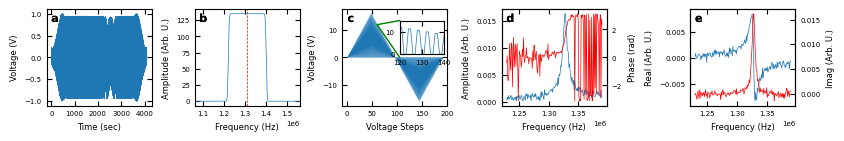

In [18]:
printer = Printer(basepath='./figures/')

Viz(printer).raw_be(dataset)

### Views the Distribution of the Least Squares Fitting (LSQF) results

It is good to view the distributions and standardize the phase shift. The phase shift is rotated around the unit circle such that the peaks are at $-\pi/2$ and $\pi/2$

dataset.scaled = False
plt.hist(dataset.SHO_fit_results()[:,:,3].flatten(), 100)

In [19]:
dataset.SHO_scaler.scale_

array([3.04434994e-05, 4.11183538e+03, 7.90251710e+01, 1.00000000e+00])

(array([100524., 172382.,  61129.,  14277.,   5225.,   2524.,   1497.,
          1044.,    834.,    666.,    597.,    516.,    521.,    486.,
           452.,    463.,    470.,    442.,    462.,    430.,    375.,
           435.,    446.,    387.,    387.,    442.,    438.,    385.,
           408.,    393.,    403.,    395.,    401.,    422.,    417.,
           435.,    392.,    443.,    443.,    466.,    572.,    686.,
           855.,    993.,   1560.,   2484.,   5934.,  29664., 168338.,
        119056.,  78332., 129471.,  50761.,  12574.,   4757.,   2400.,
          1388.,    923.,    710.,    605.,    565.,    509.,    528.,
           455.,    473.,    461.,    471.,    473.,    499.,    485.,
           450.,    467.,    429.,    381.,    431.,    426.,    449.,
           455.,    427.,    428.,    374.,    460.,    441.,    464.,
           438.,    480.,    500.,    456.,    486.,    446.,    551.,
           695.,    825.,    909.,   1391.,   2218.,   4842.,  24137.,
      

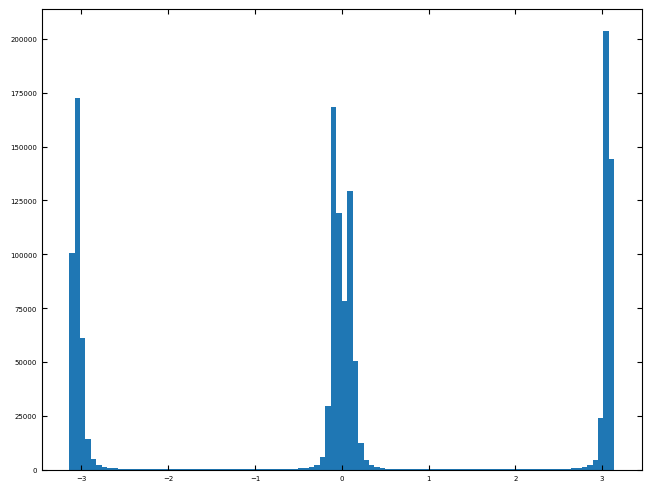

In [24]:
dataset.scaled = False
plt.hist(dataset.SHO_LSQF()[:,:,3].flatten(), 100)

In [25]:
dataset.extraction_state


                  Resample = False
                  Raw Format = complex
                  fitter = LSQF
                  scaled = False
                  Output Shape = pixels
                  Measurement State = all
                  Resample Bins = 80
                  


(array([100524., 172382.,  61129.,  14277.,   5225.,   2524.,   1497.,
          1044.,    834.,    666.,    597.,    516.,    521.,    486.,
           452.,    463.,    470.,    442.,    462.,    430.,    375.,
           435.,    446.,    387.,    387.,    442.,    438.,    385.,
           408.,    393.,    403.,    395.,    401.,    422.,    417.,
           435.,    392.,    443.,    443.,    466.,    572.,    686.,
           855.,    993.,   1560.,   2484.,   5934.,  29664., 168338.,
        119056.,  78332., 129471.,  50761.,  12574.,   4757.,   2400.,
          1388.,    923.,    710.,    605.,    565.,    509.,    528.,
           455.,    473.,    461.,    471.,    473.,    499.,    485.,
           450.,    467.,    429.,    381.,    431.,    426.,    449.,
           455.,    427.,    428.,    374.,    460.,    441.,    464.,
           438.,    480.,    500.,    456.,    486.,    446.,    551.,
           695.,    825.,    909.,   1391.,   2218.,   4842.,  24137.,
      

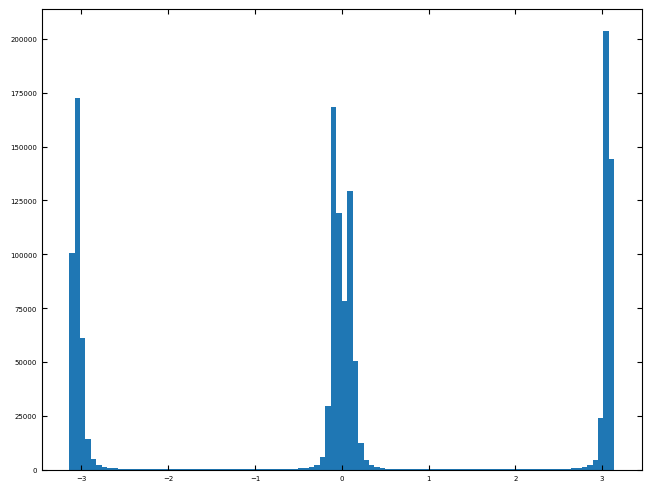

In [21]:
dataset.scaled = True
plt.hist(dataset.SHO_fit_results()[:,:,3].flatten(), 100)

In [ ]:
# dataset.measurement_state = 'off'
# dataset.resampled = True
# # dataset.raw_format = "magnitude spectrum"


In [ ]:
# plt.plot(dataset.raw_spectra(pixel=0, voltage_step=100)[0].flatten())
# plt.plot(dataset.raw_spectra(pixel=0, voltage_step=100)[1].flatten())


In [ ]:
# plt.plot(dataset.raw_spectra(pixel=0, voltage_step=100)[0].flatten())
# plt.plot(dataset.raw_spectra(pixel=0, voltage_step=100)[1].flatten())


In [ ]:
# plt.plot(dataset.raw_spectra(pixel = 0, voltage_step=100))
# plt.plot(dataset.raw_spectra[1][0,100,:])

In [ ]:
# dataset.raw_data_resampled.shape


In [ ]:
# dataset.extraction_state


### Visualize Raw Data

In [ ]:
from m3_learning.viz.layout import layout_fig

layout_fig(5,3)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize = (5, 5/3*2))

gs1 = GridSpec(1, 2, top = 0.48,
               bottom=0.05, left=0.1666, right=1-0.1666)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])

gs1 = GridSpec(1, 3, top=.98,
               bottom=.505)
ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])


def annotate_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)
        
annotate_axes(fig)        

plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(5, 5/3*2))


axs[0, 0].set_position([0, 0, 1/3, 1/2])


In [ ]:
axs[1, 0].get_position()
fig.get_size_inches()

In [ ]:
dataset.lsqf_viz.raw_be()

### Plots the SHO Fit Results

In [ ]:
dataset.lsqf_viz.SHO_loops()

### Visualize the SHO Fit Results

In [ ]:
dataset.lsqf_viz.shift = np.pi/2
dataset.lsqf_viz.SHO_hist()


## Preprocessing

### Validate Resampling

In [ ]:
dataset.lsqf_viz.raw_resampled_data(filename="Figure_4_raw_and_resampled_raw_data")


In [ ]:
dataset.lsqf_viz.SHO_hist()
dataset.SHO_Scaler(shifter = dataset.lsqf_viz)
dataset.lsqf_viz.SHO_hist(data_type="scaled")
